In [231]:
import pandas as pd
import numpy as np
# pip install patsy
from patsy import dmatrices, dmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [232]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)

- survival:        Survival
                (0 = No; 1 = Yes)

In [233]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [234]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,S
1,134,1,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.0000,S
2,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,S
3,799,0,3,"Ibrahim Shawah, Mr. Yousseff",male,30.0,0,0,2685,7.2292,C
4,871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,S


In [235]:
y, X = dmatrices('Survived ~ Age + C(Pclass) + C(Sex)', train, return_type='dataframe')
#y & X are DataFrames now with one-hot enocoding/dummy encoding

# flatten y so we can incorporate in sklearn functions
y = np.ravel(y)
#y is now an array

In [236]:
X.head()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age
0,1.0,0.0,1.0,0.0,22.0
1,1.0,1.0,0.0,0.0,29.0
2,1.0,0.0,1.0,1.0,20.0
3,1.0,0.0,1.0,1.0,30.0
4,1.0,0.0,1.0,1.0,26.0


In [237]:
# standardize the features since regularization requires all features to be on same scale
scaler = StandardScaler(copy=True)
# we have created a standardization based on the training data
X_clean = scaler.fit(X).transform(X)
#X_clean is an array

In [238]:
x_clean2 = pd.DataFrame(X_clean, columns=X.columns)
#X_clean2 is a DataFrame of standardized values

In [239]:
x_clean2.head()

,Intercept,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age
0,0.0,-0.550590,0.987988,-1.334733,-0.526716
1,0.0,1.816233,-1.012159,-1.334733,-0.045169
2,0.0,-0.550590,0.987988,0.749213,-0.664301
3,0.0,-0.550590,0.987988,0.749213,0.023623
4,0.0,-0.550590,0.987988,0.749213,-0.251546


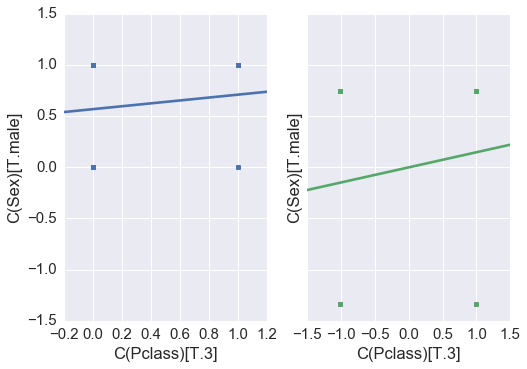

In [240]:
# comparing coeff of not-standarized data with standardized data.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
#https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side
sns.regplot(x='C(Pclass)[T.3]', y='C(Sex)[T.male]', data=X, ci=None, ax=ax1)
sns.regplot(x='C(Pclass)[T.3]', y='C(Sex)[T.male]', data=x_clean2, ci=None, ax = ax2)
#sns.lmplot(x='C(Pclass)[T.3]', y='C(Sex)[T.male]', data=X, ci=None)
#sns.lmplot(x='C(Pclass)[T.3]', y='C(Sex)[T.male]', data=x_clean2, ci=None)

In [241]:
##correlations dataframe and pair plots
#x_clean2.corr()
####scatter plots #http://seaborn.pydata.org/generated/seaborn.pairplot.html
#sns.pairplot(x_clean2)

### corrfunc (due to peason)only works with continuous data
###https://stackoverflow.com/questions/30942577/seaborn-correlation-coefficient-on-pairgrid
# def corrfunc(x, y, **kws):
#     r, _ = stats.pearsonr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.1, .9), xycoords=ax.transAxes)

# g = sns.PairGrid(x_clean2, palette=["red"])
# g.map_upper(plt.scatter, s=10)
# g.map_diag(sns.distplot, kde=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_lower(corrfunc)

In [242]:
# build our initial model with Regularization

#### Regularization ####
#L1 LASSO (absoute sum of errors) weak coef goes to zero
#L2 RIDGE (squared sum of errors)
lr = LogisticRegression('l1')
lr.fit(X_clean, y)
print (lr.coef_)

[[ 0.         -0.50094234 -1.2982726  -1.17899729 -0.5680362 ]]


# METRICS

In [243]:
from sklearn.metrics import f1_score ,accuracy_score,confusion_matrix,classification_report,log_loss
print(classification_report(y, lr.predict(x_clean2)))

             precision    recall  f1-score   support

        0.0       0.82      0.85      0.84       397
        1.0       0.76      0.73      0.75       265

avg / total       0.80      0.80      0.80       662



- ### Confusion Matrix

In [244]:
print("\n",confusion_matrix(y, lr.predict(x_clean2)),"\n\n or \n\n"
#pandas crosstab accepts Arrays
,pd.crosstab(lr.predict(x_clean2),y),"\n\n or")

fin2 = pd.DataFrame([lr.predict(x_clean2),y], index=['Pred','Actual']).T

pd.crosstab(fin2['Pred'],fin2['Actual'])


 [[337  60]
 [ 72 193]] 

 or 

 col_0  0.0  1.0
row_0          
0.0    337   72
1.0     60  193 

 or


Actual,0.0,1.0
Pred,,
0.0,337,72
1.0,60,193


In [245]:
#https://en.wikipedia.org/wiki/Precision_and_recall
#https://www.quora.com/What-is-the-best-way-to-understand-the-terms-precision-and-recall
print('Accuracy:',(lr.predict(x_clean2)==y).mean(),'\n', #Accuracy
      'Accuracy:',accuracy_score(y, lr.predict(x_clean2)),'\n' #Accuracy
,'Precision:',((lr.predict(x_clean2)==y)&(y==1)).sum()/(lr.predict(x_clean2)).sum(),'\n'
# Precision
,'Recall/Sensitivity:',((lr.predict(x_clean2)==y)&(y==1)).sum()/(y[y==1]).sum(),'\n'
#Recall or Sensitivity
,'Specificity:',((lr.predict(x_clean2)==y)&(y==0)).sum() /len(y[y==0]),'\n'
#Specificity or True negative/ConditionNegative or Negative Recall
,'F1-Score:',(2*( (((lr.predict(x_clean2)==y)&(y==1)).sum()/(y[y==1]).sum())\
      *(((lr.predict(x_clean2)==y)&(y==1)).sum()/(lr.predict(x_clean2)).sum())))/\
      ( (((lr.predict(x_clean2)==y)&(y==1)).sum()/(y[y==1]).sum())\
      +(((lr.predict(x_clean2)==y)&(y==1)).sum()/(lr.predict(x_clean2)).sum())))
#F1-Score (2*Precision*Recall)/(Precision+Recall)

Accuracy: 0.800604229607 
 Accuracy: 0.800604229607 
 Precision: 0.762845849802 
 Recall/Sensitivity: 0.728301886792 
 Specificity: 0.848866498741 
 F1-Score: 0.745173745174


# Predictions

In [246]:
# a sparse girl
girl = [1., 0., 0., 0., 21.]
girl = scaler.fit(X).transform(girl)
lr.predict_proba(girl.reshape(1,-1))

C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([[ 0.04991841,  0.95008159]])

In [247]:
print(girl)

[ 0.         -0.55059023 -1.0121585  -1.33473316 -0.59550826]


In [248]:
lr.intercept_

array([-0.55563068])

In [249]:
lr.coef_[0]

array([ 0.        , -0.50094234, -1.2982726 , -1.17899729, -0.5680362 ])

- ### Manually Calculate Prediction

In [250]:
#Add intercept + coefficients*StandardizedValues = Logodds of New values
logodds = lr.intercept_ +(-0.50089255* -0.55059023)+(-1.2981623*-1.0121585)+(-1.1789864*-1.33473316)+\
(-0.56799074* -0.59550826)
print('Log odds are ...'+str(logodds))

#Convert log-odds to jusst odds
odds = np.exp(logodds)
print('Odds of survival are ...'+str(odds))
#Pass through sigmoid function or pass through link function to get Probability
prob = odds/(1 + odds)
print('Probablity of survival is ....'+str(prob))

Log odds are ...[ 2.9459773]
Odds of survival are ...[ 19.02925051]
Probablity of survival is ....[ 0.95007302]


- ### Use a function to Calculate Prediction

In [251]:
def sigmoid(x):
    return 1/(1+np.e**(-x))

In [252]:
print('Probablity of survival is ...'+str(sigmoid( np.dot(girl, lr.coef_.T) + lr.intercept_ )))

Probablity of survival is ...[ 0.95008159]


- ### Use sklearn predict method

In [253]:
# compute predicted probability for al=2 using the predict_proba method
print('Probablity of survival is ...'+str(lr.predict_proba(girl.reshape(1,-1))[:, 1]))

Probablity of survival is ...[ 0.95008159]


# Fit without a bias term (intercept)

In [254]:
#Used X Dataframe of raw data (Not Standardized Only Dummy/One-Hot encoded)
XX = X.copy()
del XX['Intercept']
XX.head()

,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age
0,0.0,1.0,0.0,22.0
1,1.0,0.0,0.0,29.0
2,0.0,1.0,1.0,20.0
3,0.0,1.0,1.0,30.0
4,0.0,1.0,1.0,26.0


In [255]:
# standardize the features since regularization requires all features to be on same scale
scaler = StandardScaler(copy=True)
# we have created a standardization based on the training data
XX = scaler.fit(XX).transform(XX)
#XX is now an Array
pd.DataFrame(XX).head()

,0,1,2,3
0,-0.550590,0.987988,-1.334733,-0.526716
1,1.816233,-1.012159,-1.334733,-0.045169
2,-0.550590,0.987988,0.749213,-0.664301
3,-0.550590,0.987988,0.749213,0.023623
4,-0.550590,0.987988,0.749213,-0.251546


In [256]:
# build our initial model
# sklearn by default fits an intercept
# set fit_intercept = False

#L1 LASSO Regularization (append sum of absolute error) weak coeff drop to 0.
lr1 = LogisticRegression('l1',fit_intercept=False)
# fit method also accepts DataFrames
lr1.fit(pd.DataFrame(XX),pd.DataFrame(y) )
print (lr1.coef_)

[[-0.51306194 -1.24592758 -1.18690823 -0.53916797]]


C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [257]:
lr1.intercept_

0.0

In [258]:
lr.coef_[0],\
'coef of previous model (with intercept) vs new model (without intercept)',lr1.coef_

(array([ 0.        , -0.50094234, -1.2982726 , -1.17899729, -0.5680362 ]),
 'coef of previous model (with intercept) vs new model (without intercept)',
 array([[-0.51306194, -1.24592758, -1.18690823, -0.53916797]]))

In [259]:
fin = pd.DataFrame([lr1.predict(XX),y], index=['Pred','Actual']).T

In [260]:
pd.crosstab(fin['Pred'],fin['Actual'])

Actual,0.0,1.0
Pred,,
0.0,302,51
1.0,95,214


In [261]:
(lr1.predict(XX)==y).mean() ##accuracy

0.77945619335347427

In [262]:
# prediction of girl
sigmoid( np.dot(girl[1:], lr1.coef_.T) + lr1.intercept_ )

array([ 0.96919676])

# CostFunction & Optimizer

In [263]:
#Ignoring the regularization, the cost function for logistic regression is logloss
#logloss is similar to cross entropy and maximum likelihood

#below we manually compute logloss and manually optimize for best coeff (betas)

In [264]:
#Give a beta0 and betoa1 -0.9, 0.1
#b0=-0.99
#b1=0.14
b0 = 0.37296654876
b1 = 0.60609744787

b0 = -0.92
b1 = 0.75
b0 = -0.780931128764
b1 = 0.889068871236

#b0=-0.89679838  
#b1=0.1487704


rawdata = [21,2,5,31,10,0.34,.23]#Actual Variables x1 only 1 variable in this example
test_P=[]

In [265]:
#Calculate Probability through the logit function
for data in rawdata:
    P = (np.exp(1)**(b0+b1*data))/(1+np.exp(1)**(b0+b1*data))
    test_P.append(P)#suggested probability

In [266]:
[ (P,1-P) for P in test_P] #Predictions. Predict probability of 1.

[(0.99999998299086335, 1.700913665469983e-08),
 (0.73050901119766931, 0.26949098880233069),
 (0.97502074889964796, 0.02497925110035204),
 (0.99999999999765843, 2.3415713812369177e-12),
 (0.9996994985955111, 0.0003005014044888954),
 (0.38257149902640741, 0.61742850097359259),
 (0.35975094226475329, 0.64024905773524665)]

In [267]:
#### Calculate Cost function Given Predictions
####  which is probability of 1 Given b0,b1 entered above ##########

##Calculate log losss then minimize
target_list=[1,0,0,1,0,0,0] #the target given the variables from rawdata
fin=[]
nz = .000000000000001
for target,PredictionProbability in zip(target_list,test_P):
    fin.append((target*np.log(PredictionProbability+nz) + (1-target)*np.log(1-PredictionProbability+nz)))
print('The Logloss is ... '+str(-1*sum(fin))) #LogLoss
print('The Logloss is ... '+str(-1*sum(fin)+(b0+b1))) #LogLoss but with L1 regularization?
#http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/
log_loss(target_list,test_P,normalize=False)
#2.9245329377547962
#2.7279212507689738.....b0=-0.9,b1 = 0.1

The Logloss is ... 14.0390782585
The Logloss is ... 14.147216001


14.039078258491985

In [268]:
#derivative of log loss
#Give a beta0 and betoa1

deriv_finX1=[]
deriv_finX0=[]
b0=b0
b1=b1
for act,data in zip(target_list,rawdata):
    deriv_finX1.append(((act*b1)/(1+np.exp(1)**(b0+b1*data))) - ((b1*np.exp(1)**(b0+b1*data)-act*b1*np.exp(1)**(b0+b1*data))/\
                                                        (1+np.exp(1)**(b0+b1*data))))
print('derivative logloss is...'+str(sum(deriv_finX1)),sum(deriv_finX1)/len(rawdata))# <- for mean logloss is actual logloss a mean?
#http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/
#log_loss(target,PredictionProbability,normalize=False)

derivative logloss is...-3.06511088331 -0.43787298333


In [269]:
#new derivative
#https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression
intercept = [1]*len(rawdata)
#for act,data in zip(target_list,rawdata,intercept):
dev0 = []
dev1 = []
for act,p,data,ones in zip(target_list,test_P,rawdata,intercept):
    dev0.append((act-p)*ones)
    dev1.append((act-p)*data)
    print(act,'-',p,' * ',data,' = ',(act-p)*data)
print(sum(dev0)/len(rawdata),sum(dev0),sum(dev1)/len(rawdata),sum(dev1))

1 - 0.999999982991  *  21  =  3.57191869749e-07
0 - 0.730509011198  *  2  =  -1.4610180224
0 - 0.9750207489  *  5  =  -4.8751037445
1 - 0.999999999998  *  31  =  7.25887128183e-11
0 - 0.999699498596  *  10  =  -9.99699498596
0 - 0.382571499026  *  0.34  =  -0.130074309669
0 - 0.359750942265  *  0.23  =  -0.0827427167209
-0.492507383282 -3.44755168297 -2.36370477457 -16.545933422


In [270]:
alpha =0.1
# print('b0 =',b0-alpha*(sum(deriv_fin)+(b0+b1)))#,sum(new_b0))
# print('b1 =',b1-alpha*(sum(deriv_finX1)+(b0+b1)))
print('b0 =',b0+alpha*(sum(dev0)/(len(rawdata) )))#,sum(new_b0))
print('b1 =',b1+alpha*(sum(dev1)/(len(rawdata) )))
print('\n')
#why divide derivative by number of number of rows???? and 
#switched update to plus(+)? thought we wanted (-) always
#how do I add L1 or L2 regularizer?? 1/#of rows + sum(betas)??

b0 = -0.830181867092
b1 = 0.652698393779




In [271]:
b0 , b1

(-0.780931128764, 0.889068871236)

In [272]:
#update statement not sure which update statement ?? 
#http://iamtrask.github.io/2015/07/27/python-network-part2/
#http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
#http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/
#http://www.cbcb.umd.edu/~hcorrada/PML/homeworks/HW04_solutions.pdf
#http://www.robots.ox.ac.uk/~az/lectures/ml/2011/lect4.pdf


In [273]:
#### Optimizer of Costfunction Given :b01,b1, derivative of logloss and learning rate ######

#b0=b0+alpha*(y-prediction)*prediction*(1-prediction)*x0
#b1=b1+alpha*(y-prediction)*prediction*(1-prediction)*x1

#ANSWER KEY WHAT coeff should be
exampl = pd.DataFrame.from_dict({'x':rawdata,'y':target_list})
y4, X4 = dmatrices('y ~ x', exampl, return_type='dataframe')
# flatten y so we can incorporate in sklearn functions
y4 = np.ravel(y4)
# lr1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
#           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
#           verbose=0, warm_start=False)
lr1 = LogisticRegression(max_iter=10000,fit_intercept=True,penalty ='l1',solver='liblinear',tol=.0001)
lr1.fit(X4,y4 )
print (lr1.coef_)
#try other cofficients to see if you can do better sklearn

[[-1.23436301  0.12894553]]


In [274]:
#lr1
#bet0, bet1

In [275]:
##Probably dont need this
#alpha =0.3
#b0=
#x0=1
# new_b0=[]
# new_b1=[]
# for target,data,PredictionProbability in zip(target_list,rawdata,test_P):
#     #new_b0.append(alpha*(target-PredictionProbability)*PredictionProbability*(1-PredictionProbability)*x0)
#     new_b0.append(alpha*(b1*((target-1)*(np.exp(1)**(b0+b1*data))+target)/(np.exp(1)**(b0+b1*data)+1)))
# #b1=
#     #new_b1.append(alpha*(target-PredictionProbability)*PredictionProbability*(1-PredictionProbability)*data)
#     new_b1.append(alpha*(b1*((target-1)*(np.exp(1)**(b0+b1*data))+target)/(np.exp(1)**(b0+b1*data)+1)))
# if abs(sum(deriv_fin))<=0.0001:
#     print('should\'ve stopped betas good!\n')
# elif sum(deriv_fin)<0:
#     print('b0 =',b0+sum(new_b0))#,sum(new_b0))
#     print('b1 =',b1+sum(new_b1))#,sum(new_b1))
#     print('\n Slope is negative go forward')
# elif sum(deriv_fin)>0:
#     print('b0 =',b0-sum(new_b0))#,sum(new_b0))
#     print('b1 =',b1-sum(new_b1))#,sum(new_b1))
#     print('\n Slope is positive go backward')

In [276]:
newD = pd.DataFrame(rawdata,columns=['X1'])
newD['intercept']=intercept
newD['target_list'] = target_list

In [277]:
newD

,X1,intercept,target_list
0,21.00,1,1
1,2.00,1,0
2,5.00,1,0
3,31.00,1,1
4,10.00,1,0
5,0.34,1,0
6,0.23,1,0


In [753]:
bet0= 0
bet1= 0

beta0,beta1,logloss,accuracy,derivativeX0 =[],[],[],[],[]
derivativeX1,loglossM,derivativeX0M,derivativeX1M =[],[],[],[]
deriv_old=[]

for it in range(1000):
#MODEL output is Probability of 1
    beta0.append(bet0)
    beta1.append(bet1)
    
    test_P=[]
    for data in newD['X1']:
        P = (np.exp(1)**(bet0+bet1*data))/(1+np.exp(1)**(bet0+bet1*data))
        test_P.append(P)
    fin=[]
    nz = .000000000000001

    #COST/LOSS FUNCTION #helps compare outcome vs other versions of model
    for target,PredictionProbability in zip(newD['target_list'],test_P):
        fin.append((target*np.log(PredictionProbability+nz) + (1-target)*np.log(1-PredictionProbability+nz)))
    #print('The Logloss is ... '+str(-1*sum(fin))) #LogLoss
    #print('The Logloss is ... '+str(-1*sum(fin)+(b0+b1)))
    logloss.append(-1*sum(fin))
    loglossM.append(-1*sum(fin)/len(rawdata))
    
    #OLD DERIVATIVE
    deriv_finX1=[]
    b0=bet0
    b1=bet1
    for act,data in zip(newD['target_list'],newD['X1']):
        deriv_finX1.append(((act*bet1)/\
                            (1+np.exp(1)**(bet0+bet1*data)))-((bet1*np.exp(1)**(bet0+bet1*data)-act*bet1*np.exp(1)**(bet0+bet1*data))/(1+np.exp(1)**(bet0+bet1*data))))
        
    deriv_old.append(sum(deriv_finX1))#/len(rawdata))
        
    #DERIVATIVE
    dev0 = []
    dev1 = []
    for act,p,data,ones in zip(newD['target_list'],test_P,newD['X1'],newD['intercept']):
        dev0.append((act-p)*ones)
        dev1.append((act-p)*data)
        #print(act,'-',p,' * ',data,' = ',(act-p)*data)
    #print(sum(dev0)/len(rawdata),sum(dev0),sum(dev1)/len(rawdata),sum(dev1))
    derivativeX0.append(sum(dev0))
    derivativeX0M.append(sum(dev0)/len(rawdata))
    derivativeX1.append(sum(dev1))
    derivativeX1M.append(sum(dev1)/len(rawdata))
    
    #Pg24 #http://www.hlt.utdallas.edu/~vgogate/ml/2015s/lectures/lr-nb-lec6.pdf
    #UPDATE .01 is the difference
    alpha =1/100
    #**2 L2  + abs L1
    # print('b0 =',b0-alpha*(sum(deriv_fin)+(b0+b1)))#,sum(new_b0))
    # print('b1 =',b1-alpha*(sum(deriv_finX1)+(b0+b1)))
    #print('b0 =',bet0+alpha*(sum(dev0)/(len(newD['X1']) )))#,sum(new_b0))
    #print('b1 =',bet1+alpha*(sum(dev1)/(len(newD['X1']) )))
    #print('\n')
    
    accu = [ 1 if x==i else 0 for (x,i) in zip([ 1 if v>.5 else 0 for v in test_P ],target_list)]
    accuracy.append(sum(accu)/len(accu))
    
    lmda=1
    bet0 = bet0+(alpha*(sum(dev0)-lmda*(bet0)))#+abs(bet0)))#-(1*abs(bet0))))#/(len(rawdata) ))
    bet1 = bet1+(alpha*(sum(dev1)-lmda*(bet1)))#+abs(bet1)))#-(1*abs(bet1))))#/(len(rawdata) ))

    
    #bet0 = bet0+alpha*(sum(dev0)-2*lmda*bet0)#((sum(dev0)-(1*abs(bet0)))/(len(rawdata) ))
    #bet1 = bet1+alpha*(sum(dev1)-2*lmda*bet1)#((sum(dev1)-(1*abs(bet1)))/(len(rawdata) ))
#got -2*lmda*bet1 from coursera below
#https://www.coursera.org/learn/ml-classification/lecture/4JxyQ/learning-l2-regularized-logistic-regression-with-gradient-ascent
#enter it results in dataframe
#


In [754]:
bet0, bet1
#sum(dev0),sum(dev1)

(-1.2429265061220931, 0.11764581702327427)

In [755]:
end = pd.DataFrame({'beta0':beta0 ,
'beta1':beta1 ,
'logloss':logloss, 
'accuracy':accuracy ,
'derivativeX0':derivativeX0, 
'derivativeX1':derivativeX1 ,
'loglossM':loglossM ,
'derivativeX0M':derivativeX0M, 
'derivativeX1M':derivativeX1M,
'derivaive_old':deriv_old })

In [756]:
end.to_csv('logistic_results.csv')

In [757]:
lr1.coef_
#print(lr1.score) array([[-0.89679838,  0.1487704 ]])

array([[-1.23436301,  0.12894553]])

In [758]:
print( np.exp(-2.10401765577),
np.exp(-4.2349469673588249),
np.exp(-0.91971246))

0.121965427474 0.0144805781207 0.398633647726


In [759]:
P_out = []
for x in newD['X1']:
    P_out.append(lr1.predict_proba([1,x])[0][1])

C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hvill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning

In [760]:
log_loss(target_list,test_P,normalize=False)
#test_P logloss 

2.2558127655538804

In [761]:
#sklearns logloss given same data
log_loss(target_list,P_out,normalize=False)
#P_out l2 --> 1.666743570068294

1.9240461883869853

In [762]:
#end.iloc[70:100,:] 
lr1.coef_

array([[-1.23436301,  0.12894553]])

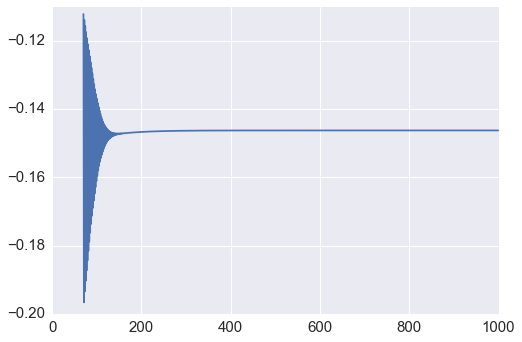

In [763]:
plt.plot('derivaive_old',data = end.iloc[70:,:])
#https://matplotlib.org/users/pyplot_tutorial.html

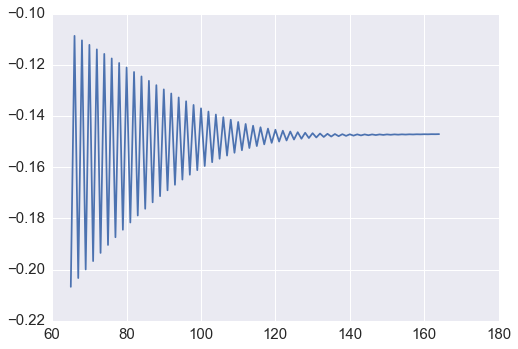

In [764]:
plt.plot('derivaive_old',data = end.iloc[65:165,:])

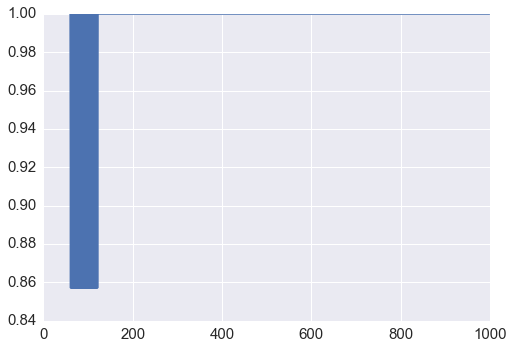

In [765]:
plt.plot('accuracy',data = end.iloc[60:,:])

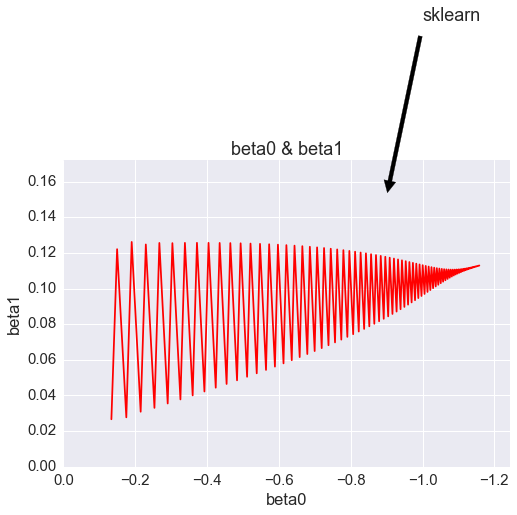

In [766]:
#fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True)
#https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side
#sns.tsplot(x='beta0', y='beta1', data=end)
sns.set_style("darkgrid")
plt.title('beta0 & beta1')
plt.xlabel('beta0')
plt.ylabel('beta1')
plt.axis([end[['beta0', 'beta1']].max()[0], end[['beta0', 'beta1']].min()[0],end[['beta0', 'beta1']].min()[1],end[['beta0', 'beta1']].max()[1]])
plt.annotate('sklearn', xy=(-0.89679838,  0.1487704 ), xytext=(-1, 0.25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot('beta0', 'beta1',data=end[['beta0', 'beta1']].iloc[6:150,:], color="red")

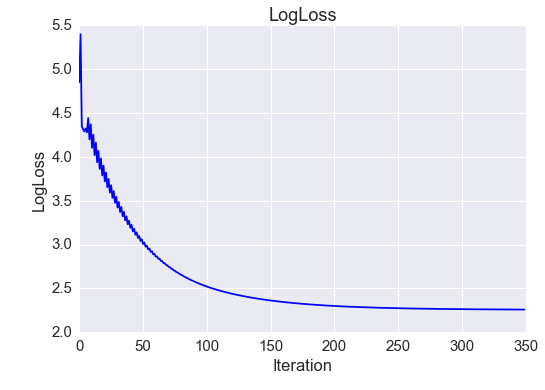

In [767]:
sns.set_style("darkgrid")
plt.title('LogLoss')
plt.xlabel('Iteration')
plt.ylabel('LogLoss')
#plt.axis([0.01, -2.7,-0.019,0.32])
plt.annotate('sklearn', xy=(87, 1.666743570068294 ), xytext=(150, 3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot('logloss',data=end.iloc[:350,:], color="blue")
#sns.regplot(x='derivativeX0', y='index', data=end.reset_index())

In [768]:
end.iloc[90:100,:]#array([[-0.89679838,  0.1487704 ]])

,accuracy,beta0,beta1,derivaive_old,derivativeX0,derivativeX0M,derivativeX1,derivativeX1M,logloss,loglossM
90,1.000000,-1.005424,0.096957,-0.129519,-1.335839,-0.190834,1.671616,0.238802,2.579837,0.368548
91,0.857143,-1.008729,0.112703,-0.168978,-1.499311,-0.214187,-1.351237,-0.193034,2.573575,0.367654
92,1.000000,-1.013634,0.098064,-0.131126,-1.337142,-0.191020,1.525897,0.217985,2.567095,0.366728
93,0.857143,-1.016869,0.112342,-0.166816,-1.484889,-0.212127,-1.208506,-0.172644,2.560965,0.365852
94,1.000000,-1.021550,0.099134,-0.132678,-1.338369,-0.191196,1.386882,0.198126,2.554948,0.364993
95,0.857143,-1.024718,0.112011,-0.164783,-1.471132,-0.210162,-1.072783,-0.153255,2.548988,0.364141
96,1.000000,-1.029182,0.100163,-0.134167,-1.339476,-0.191354,1.255110,0.179301,2.543369,0.363338
97,0.857143,-1.032285,0.111713,-0.162884,-1.458055,-0.208294,-0.944589,-0.134941,2.537604,0.362515
98,1.000000,-1.036543,0.101150,-0.135584,-1.340424,-0.191489,1.131056,0.161579,2.532330,0.361761
99,0.857143,-1.039581,0.111449,-0.161119,-1.445671,-0.206524,-0.824372,-0.117767,2.526777,0.360968


In [699]:
#Figure Out how to apply l1 & l2